In [7]:
import pandas as pd
import numpy as np
import random as rand
from sklearn import preprocessing
from sklearn.svm import LinearSVC                          
from sklearn.model_selection import GridSearchCV          
from sklearn.metrics import classification_report                                     
import statistics
import warnings
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, f1_score ,auc,roc_curve

In [8]:
warnings.filterwarnings('ignore')
precision=[]
recall= []
fscore = []
AUC=[] 
accuracy_sc=[]
precision_train=[]
recall_train= []
fscore_train = []
AUC_train=[] 
accuracy_sc_train=[]

In [9]:
for m in range(30):
    data= pd.read_csv('wdbc.data')
    data.columns=['IDs','Diagnosis','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','f12','f13','f14','f15','f16','f17','f18','f19','f20','f21','f22','f23','f24','f25','f26','f27','f28','f29','f30']

    data_x = data.drop(['IDs','Diagnosis'],axis=1)
    data_x_nomalize = pd.DataFrame(preprocessing.normalize(data_x))
    data = pd.concat([data[['Diagnosis']],data_x_nomalize],axis=1)
    data["Diagnosis"] = data["Diagnosis"].map( {'M':0, 'B':1} )

    data_malignant = data[ data['Diagnosis'] == 0]
    data_malignant_50_test = data_malignant.sample(frac=.50,random_state=rand.randint(0,100))

    data_benign = data[data['Diagnosis'] == 1]
    data_benign_50_test= data_benign.sample(frac=.50,random_state=rand.randint(1,100))

    test_data = pd.concat([data_malignant_50_test,data_benign_50_test]) 
    train_data = data.drop(index= test_data.index)
    
    label_data = train_data
    unlabeled_data = test_data.drop('Diagnosis',axis=1)
    unlabeled_data_y = test_data['Diagnosis']
    unlabeled_data_final =unlabeled_data.reset_index(drop=True)
    unlabeled_data =unlabeled_data_final
    
    labeled_x = train_data.drop(['Diagnosis'],axis=1)
    labeled_x = labeled_x.reset_index(drop=True)
    labeled_y=train_data['Diagnosis']
    labeled_y=labeled_y.reset_index(drop=True)
    
    labeled_x_final = train_data.drop(['Diagnosis'],axis=1)
    labeled_x_final = labeled_x_final.reset_index(drop=True)
    labeled_y_final=train_data['Diagnosis']
    labeled_y_final=labeled_y_final.reset_index(drop=True)
    
    for un in range(len(unlabeled_data)):
        parameters = [{'C': [0.1,1, 10, 100],'max_iter':[2000]}]
        # parameters = [{'C': [1, 10],'max_iter':[2000]}]
        clf = GridSearchCV(LinearSVC(penalty='l1',dual=False),parameters,cv=5)
        clf.fit(labeled_x,labeled_y)
        decision_scores = clf.decision_function(unlabeled_data)
        l = int(np.argmax(np.abs(decision_scores)))                       # Get most confident prediction
        # l = int(np.argmin(np.abs(decision_scores)))                     # use argmin for least confident prediction
        max_dist_val = pd.Series.to_frame(unlabeled_data.iloc[l,:]).T
        pred_app = pd.DataFrame(clf.predict(max_dist_val))
        labeled_x = pd.concat([labeled_x,max_dist_val], ignore_index=True)
        labeled_y = pd.concat([labeled_y,pred_app],axis=0)
        unlabeled_data = unlabeled_data.drop(index=l,axis=0)
        unlabeled_data = unlabeled_data.reset_index(drop=True)
    
    final_model = GridSearchCV(LinearSVC(penalty='l1', dual=False), parameters, cv=5)
    final_model.fit(labeled_x, labeled_y)
    
    #test
    pred_final = clf.predict(unlabeled_data_final)
    precision.append(precision_score(unlabeled_data_y, pred_final))
    recall.append(recall_score(unlabeled_data_y,pred_final))
    accuracy_sc.append(accuracy_score(unlabeled_data_y, pred_final)) 
    fscore.append(f1_score(unlabeled_data_y, pred_final))
    fpr, tpr, _ = roc_curve(unlabeled_data_y,pred_final)
    AUC.append(auc(fpr, tpr))
    
    
    #train
    pred_final_train=clf.predict(labeled_x_final) #train
    #pred_y_tr = model.predict(x_lab)
    precision_train.append(precision_score(labeled_y_final, pred_final_train))
    recall_train.append(recall_score(labeled_y_final,pred_final_train))
    accuracy_sc_train.append(accuracy_score(labeled_y_final, pred_final_train)) 
    fscore_train.append(f1_score(labeled_y_final, pred_final_train))
    fpr_tr, tpr_tr, _ = roc_curve(labeled_y_final,pred_final_train)
    AUC_train.append(auc(fpr_tr, tpr_tr))
    
    
print("\nTEST values")
print("avg precision score: ",statistics.mean(precision))
print("avg f1 score: ",statistics.mean(fscore))
print("avg recall score: ",statistics.mean(recall))
print("avg AUC score: ",statistics.mean(AUC))
print("avg acuracy score: ",statistics.mean(accuracy_sc))
    
print("\nTrain Values")
print("avg  precision score: ",statistics.mean(precision_train))
print("avg  f1 score: ",statistics.mean(fscore_train))
print("avg  recall score: ",statistics.mean(recall_train))
print("avg AUC score: ",statistics.mean(AUC_train))
print("avg acuracy score: ",statistics.mean(accuracy_sc_train))   
    


TEST values
avg precision score:  0.9439079210653207
avg f1 score:  0.9546996227198292
avg recall score:  0.9661048689138577
avg AUC score:  0.9344675287965515
avg acuracy score:  0.9424882629107981

Train Values
avg  precision score:  0.9481636976169985
avg  f1 score:  0.9566391131633709
avg  recall score:  0.9653631284916201
avg AUC score:  0.937602199166445
avg acuracy score:  0.9448356807511736


Test Area under the curve


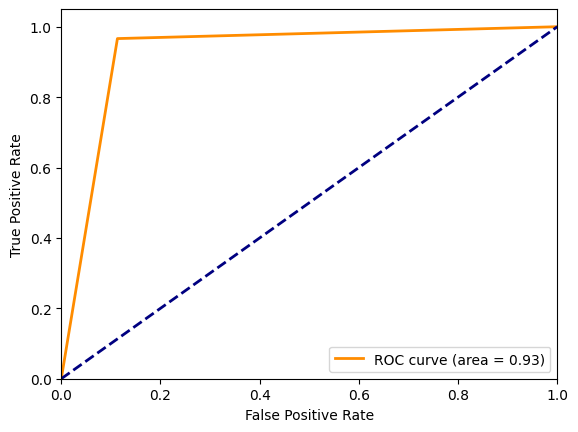

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

print("Test Area under the curve")
plt.figure()
lw=2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' %auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

Train Area under the curve


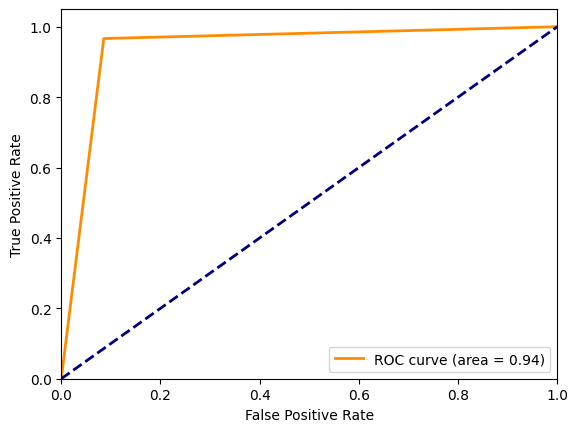

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

print("Train Area under the curve")
plt.figure()
lw=2
plt.plot(fpr_tr, tpr_tr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' %auc(fpr_tr, tpr_tr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [12]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(unlabeled_data_y, pred_final)
print("Confusion Matrix test: ")
print(conf)

conf_tr = confusion_matrix(labeled_y_final, pred_final_train)
print("Confusion Matrix train: ")
print(conf_tr)

Confusion Matrix test: 
[[ 94  12]
 [  6 172]]
Confusion Matrix train: 
[[ 96   9]
 [  6 173]]
